# <font style="color:blue">Assignment: Implement a CNN for Image Classification on CIFAR10 dataset</font>

We have seen how to implement a CNN (LeNet5 and LeNet with the batch norm) in the last section. We used MNIST and Fashion MNIST dataset which are grayscale or single channel datasets. In this assignment, you will implement a CNN Model ( similar to LeNet ) for classifying objects in the `CIFAR10` dataset. 

The CIFAR10 dataset has the following properties
1. It has `10` classes.  
1. It has colored images, so it has `3-channels`. 
1. The image shape is `32 x 32`.

Samples of CIFAR10- dataset ([source](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar)):

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_cirar10.png" width=700>


# <font color='blue'>Marking Scheme</font>

### <font style="color:green">Maximum Points: 30

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Problem</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Implement the CNN Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Find Mean and Std of Training Data</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Model Training & Accuracy</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font color='blue'>Problem Description</font>

### <font color='blue'>1. Implement the CNN Model</font>
Since the task is to classify objects in a dataset of color images, you need to implement a CNN with 10 output classes. **Also, your model must use `Conv2d`, `BatchNorm2d`, and `ReLU`.** 

**You need to define the model architecture in the function: `MyModel` ( Step 1 )**

Hint: For color images you need to use an input shape that is different than the ones we have been using till now, so that it accepts 3 channel inputs.

### <font color='blue'>2. Find Mean and Std of Training Data</font>

It is a good practice to normalize the training data. To normalize the data, we need to compute mean and std. As the dataset has colored images, it has `3-channel` (RGB or BGR). We have to find mean and std per channel using training data. 

**You need to compute the mean and std for the dataset in the function: `get_mean_std_train_data` ( Step 3 )**

### <font color='blue'>3. Model Training and Accuracy</font>

Once you have defined the model, you can train it. To get better accuracy, you need to play around the training configuration **( Step 5 )** and even the model architecture. You can check the accuracy by running the training loop in `Step 11`.

Here are a few hints on how you can improve the accuracy:
- Train for longer duration
- Try with different learning rate
- Try to add more convolutional layers to the architecture
- Try to add more nodes in the layers.

You need to achieve **75% accuracy** ( See Step11 ) in order to get full marks for this part. 

**You do not need to implement anything for this, just changing the parameters as mentioned above and running the Notebook will give you the accuracy. ( Step 5 and Step 11 )**

Note that this notebook requires you to change a few stuff in the model to get the desired accuracy. Therefore you need train the model all over again (which seems to be time-consuming).   

You can choose to execute this notebook in Google-Colab so that you have access to a GPU-machine and prototype faster.   

Once the desired results are acheived, you can copy-paste the changes made in the Colab-notebook to this notebook so that the grading occurs on the latest code. 

You can access the Colab-notebook from [here](https://colab.research.google.com/drive/18lgSRmHPagJkB0xmDq5ZiWGkuWcHnUc2?usp=sharing)

In [1]:
required_training = True

In [2]:
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [3]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [4]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision

# <font style="color:blue">1. CNN Model Architecture [10 Points]</font>

You have to write the model code here. You can take reference from LeNet code.

If you do not get higher accuracy, here are a few hints:
- Try to add more convolutional layers to the architecture
- Try to add more nodes in the layers.


In [124]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (32, 32)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # output size = (16, 16)
            
            # Second convolution layer
            # input size = (16, 16), output size = (16, 16)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # output size = (8, 8)
            
            # Third convolution layer
            # input size = (8, 8), output size = (8, 8)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer
            nn.Linear(in_features=64 * 8 * 8, out_features=120), 
            nn.ReLU(inplace=True),
            
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )
        
    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        
        return x

# <font style="color:blue">2. Display the Network</font>

In [54]:
my_model = MyModel()
print(my_model)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [8]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [9]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [10]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [11]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


# <font style="color:blue">3. Find Mean and STD of CIFAR10 Data [5 Points]</font>

Function **`get_mean_std_train_data`** should `return` `mean` and `std` of training data. You can refer to the code used in the previous section for finding the mean and std of the training data.



In [55]:
def get_mean_std_train_data(data_root):
    
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_transform)
    
    # return mean (numpy.ndarray) and std (numpy.ndarray)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    data = train_set.data / 255
    mean = data.mean(axis= (0,1,2))
    std  = data.std(axis = (0,1,2))

    return mean, std


get_mean_std_train_data("../resource/lib/publicdata/images")

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [13]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [14]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [56]:
def get_data(batch_size, data_root, num_workers=1):
    
    
    try:
        mean, std = get_mean_std_train_data(data_root)
        assert len(mean) == len(std) == 3
    except:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
    
    train_test_transforms = transforms.Compose([
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean and divide by variance.
        transforms.Normalize(mean, std)
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=data_root, train=False, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>


In [57]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration [15 Points]</font>
All training parameters are defined here. So, 
This is where you can improve your accuracy, apart from improving the architecture. 

Here are a few hints on how you can improve the accuracy:
- Train for longer duration
- Try with different learning rate

**You need to achieve 75% accuracy in order to get full marks for this part.**

**You will see the effect of these changes when you run Step 11**

In [128]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 2  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.1  # determines the speed of network's weights update
        
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "../resource/lib/publicdata/images"  # folder to save data
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    # update changed parameters in blow coding block.
    # Please do not change "data_root" 
    
    ###
    batch_size: int = 32
    epochs_count: int = 17
    learning_rate: float = 0.005
    ###


# <font style="color:blue">6. System Setup</font>


In [59]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch. The following steps are performed in the code below:

1. Send the data to the required device ( CPU/GPU )
1. Make a forward pass using the forward method.
1. Find the loss using the Cross_Entropy function.
1. Find the gradients using the backward function.
1. Update the weights using the optimizer.
1. Find the accuracy of the model

Repeat the above for the specified number of epochs.

In [60]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

After every few epochs **`validation`** will be called with the `trained model` and `test_loader` to get validation loss and accuracy.

In [20]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Saving the Model</font>

In [21]:
def save_model(model, device, model_dir='models', model_file_name='cifar10_cnn_model.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    if int(torch.__version__.split('.')[1]) >= 6:
        torch.save(model.state_dict(), model_path, _use_new_zipfile_serialization=False)
    
    else:
        torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

# <font style="color:blue">10. Main</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc
1. Load the data using dataloaders
1. Create an instance of the LeNet model
1. Specify optimizer to use.
1. Set up variables to track loss and accuracy and start training.
1. If loss decreases, saving the model

In [22]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=training_configuration.batch_size,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = MyModel()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    best_accuracy = torch.tensor(0)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
            
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                print('Accuracy improved, saving the model.\n')
                save_model(model, device)
            
                
    print("Total time: {:.2f}, Best Loss: {:.3f}, Best Accuracy: {:.3f}".format(time.time() - t_begin, best_loss, 
                                                                                best_accuracy))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [23]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


# <font style="color:blue">Step 11: Start Training</font>
This is where you start the training. You may see that the training does not converge or does not give a good accuracy. You need to change 
- In Step 1: the network architecture and add a few more layers or more nodes to the already existing layers
- In Step 5: training parameters such as learning rate or batch_size or epochs so that the network converges or run the network for longer so that it gets more time to fit the data

**You need to make sure that the accuracy at the end is at least 75%.**

In [129]:
if required_training:
    model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Train Epoch: 0 [1600/50000] Loss: 2.296854 Acc: 0.1875
Train Epoch: 0 [3200/50000] Loss: 2.084887 Acc: 0.3750
Train Epoch: 0 [4800/50000] Loss: 2.072021 Acc: 0.1875
Train Epoch: 0 [6400/50000] Loss: 1.783385 Acc: 0.3750
Train Epoch: 0 [8000/50000] Loss: 1.757373 Acc: 0.3750
Train Epoch: 0 [9600/50000] Loss: 1.702693 Acc: 0.4375
Train Epoch: 0 [11200/50000] Loss: 1.542557 Acc: 0.5000
Train Epoch: 0 [12800/50000] Loss: 1.432416 Acc: 0.6875
Train Epoch: 0 [14400/50000] Loss: 1.360379 Acc: 0.3750
Train Epoch: 0 [16000/50000] Loss: 1.745413 Acc: 0.2500
Train Epoch: 0 [17600/50000] Loss: 1.111062 Acc: 0.5625
Train Epoch: 0 [19200/50000] Loss: 1.354132 Acc: 0.3750
Train Epoch: 0 [20800/50000] Loss: 1.104786 Acc: 0.6250
Train Epoch: 0 [22400/50000] Loss: 1.453595 Acc: 0.5000
Train Epoch: 0 [24000/50000] Loss: 1.461095 Acc: 0.5625
Train Epoch: 0 [25600/50000] Loss: 1.691467 Acc: 0.4375
Train Epoch: 0 [27200/50000] Loss: 1.878480 Acc: 0.2500
Train Epoch: 0 [28800/50000] Loss: 1.297416 Acc: 0.750

Train Epoch: 4 [20800/50000] Loss: 0.998794 Acc: 0.6875
Train Epoch: 4 [22400/50000] Loss: 0.824389 Acc: 0.6875
Train Epoch: 4 [24000/50000] Loss: 0.733730 Acc: 0.6875
Train Epoch: 4 [25600/50000] Loss: 0.606380 Acc: 0.8125
Train Epoch: 4 [27200/50000] Loss: 0.505164 Acc: 0.8750
Train Epoch: 4 [28800/50000] Loss: 0.540718 Acc: 0.6875
Train Epoch: 4 [30400/50000] Loss: 0.655167 Acc: 0.7500
Train Epoch: 4 [32000/50000] Loss: 0.760375 Acc: 0.7500
Train Epoch: 4 [33600/50000] Loss: 0.709271 Acc: 0.8125
Train Epoch: 4 [35200/50000] Loss: 1.013752 Acc: 0.5625
Train Epoch: 4 [36800/50000] Loss: 0.983064 Acc: 0.5000
Train Epoch: 4 [38400/50000] Loss: 0.653739 Acc: 0.7500
Train Epoch: 4 [40000/50000] Loss: 0.600236 Acc: 0.8125
Train Epoch: 4 [41600/50000] Loss: 1.044475 Acc: 0.7500
Train Epoch: 4 [43200/50000] Loss: 0.554435 Acc: 0.7500
Train Epoch: 4 [44800/50000] Loss: 0.703535 Acc: 0.7500
Train Epoch: 4 [46400/50000] Loss: 0.612533 Acc: 0.8125
Train Epoch: 4 [48000/50000] Loss: 1.170135 Acc:

Train Epoch: 8 [41600/50000] Loss: 0.734203 Acc: 0.8750
Train Epoch: 8 [43200/50000] Loss: 0.493016 Acc: 0.8125
Train Epoch: 8 [44800/50000] Loss: 0.299640 Acc: 0.9375
Train Epoch: 8 [46400/50000] Loss: 0.242370 Acc: 0.9375
Train Epoch: 8 [48000/50000] Loss: 0.415370 Acc: 0.8125
Train Epoch: 8 [49600/50000] Loss: 0.185939 Acc: 1.0000
Elapsed 339.64s, 37.74 s/epoch, 0.01 s/batch, ets 301.90s

Test set: Average loss: 0.7628, Accuracy: 7459/10000 (75%)

Accuracy improved, saving the model.

Train Epoch: 9 [1600/50000] Loss: 0.349580 Acc: 0.9375
Train Epoch: 9 [3200/50000] Loss: 0.764861 Acc: 0.6250
Train Epoch: 9 [4800/50000] Loss: 0.436588 Acc: 0.7500
Train Epoch: 9 [6400/50000] Loss: 0.317301 Acc: 0.9375
Train Epoch: 9 [8000/50000] Loss: 0.514839 Acc: 0.7500
Train Epoch: 9 [9600/50000] Loss: 0.398442 Acc: 0.8125
Train Epoch: 9 [11200/50000] Loss: 0.466400 Acc: 0.8125
Train Epoch: 9 [12800/50000] Loss: 0.514146 Acc: 0.7500
Train Epoch: 9 [14400/50000] Loss: 0.429706 Acc: 0.8125
Train Epo

Train Epoch: 13 [8000/50000] Loss: 0.193758 Acc: 0.9375
Train Epoch: 13 [9600/50000] Loss: 0.751109 Acc: 0.8125
Train Epoch: 13 [11200/50000] Loss: 0.077432 Acc: 1.0000
Train Epoch: 13 [12800/50000] Loss: 0.233971 Acc: 0.9375
Train Epoch: 13 [14400/50000] Loss: 0.097419 Acc: 0.9375
Train Epoch: 13 [16000/50000] Loss: 0.190263 Acc: 0.9375
Train Epoch: 13 [17600/50000] Loss: 0.121257 Acc: 1.0000
Train Epoch: 13 [19200/50000] Loss: 0.119402 Acc: 0.9375
Train Epoch: 13 [20800/50000] Loss: 0.033561 Acc: 1.0000
Train Epoch: 13 [22400/50000] Loss: 0.229530 Acc: 0.8750
Train Epoch: 13 [24000/50000] Loss: 0.342520 Acc: 0.8750
Train Epoch: 13 [25600/50000] Loss: 0.452271 Acc: 0.6875
Train Epoch: 13 [27200/50000] Loss: 0.200646 Acc: 0.9375
Train Epoch: 13 [28800/50000] Loss: 0.092975 Acc: 0.9375
Train Epoch: 13 [30400/50000] Loss: 0.149832 Acc: 0.9375
Train Epoch: 13 [32000/50000] Loss: 0.284507 Acc: 0.8750
Train Epoch: 13 [33600/50000] Loss: 0.297565 Acc: 0.8750
Train Epoch: 13 [35200/50000] Los

# <font style="color:blue">12. Plot Loss</font>

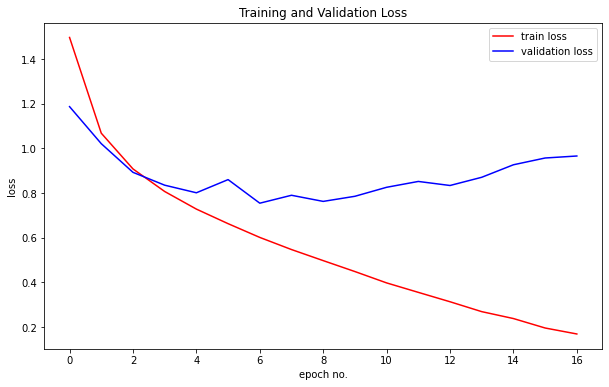

In [130]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font style="color:blue">13. Plot Accuracy</font>

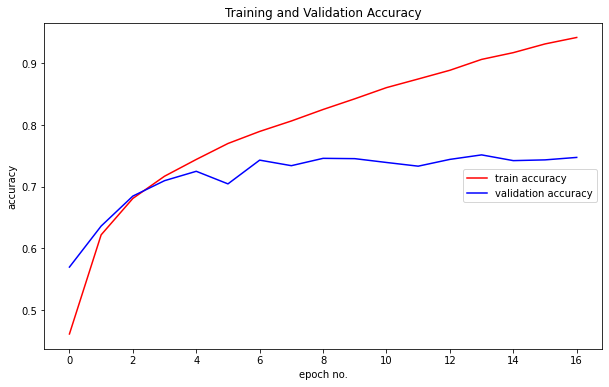

In [131]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

# <font style="color:blue">14. Loading the Model </font>


In [101]:
# initialize the model
cnn_model = MyModel()

models = 'models'

model_file_name = 'cifar10_cnn_model.pt'

model_path = os.path.join(models, model_file_name)

# loading the model and getting model parameters by using load_state_dict
cnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# <font style="color:blue">15. Model Prediction</font>


In [102]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

# <font style="color:blue">16. Perform Inference on sample images </font>

For prediction, we need to transform the data in the same way as we have done during training. 

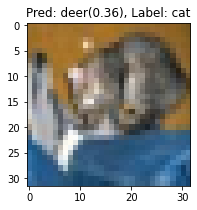

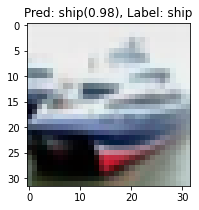

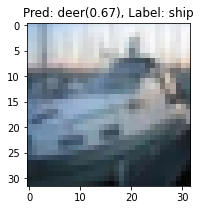

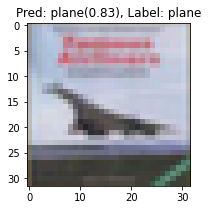

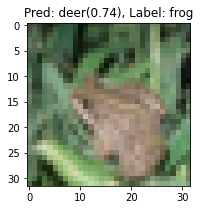

In [103]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"
    
    

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=train_config.data_root, train=False, download=False, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

try:
    mean, std = get_mean_std_train_data(data_root)
    assert len(mean) == len(std) == 3
except:
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

# load testdata with image transformation
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=train_config.data_root, train=False, download=False, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(cnn_model, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, label in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img)
        plt.gca().set_title('Pred: {0}({1:0.2}), Label: {2}'.format(classes[pred[i]], prob[i], classes[label[i]]))
        plt.show()
    break

# <font style="color:blue">17. Report your findings</font>
- 
- 

# <font style="color:blue">References</font>

1. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
1. https://pytorch.org/tutorials/beginner/saving_loading_models.html